In [37]:
import numpy as np
import matplotlib.pyplot as plt


In [38]:
import random
from sklearn.neighbors import NearestNeighbors
import numpy as np
class Smote:
    def __init__(self,samples,N=10,k=5):
        self.n_samples,self.n_attrs=samples.shape
        self.N=N
        self.k=k
        self.samples=samples
        self.newindex=0

    def over_sampling(self):
        N=int(self.N)
        self.synthetic = np.zeros((self.n_samples * N, self.n_attrs))
        neighbors=NearestNeighbors(n_neighbors=self.k).fit(self.samples)  
        for i in range(len(self.samples)):
#             print('samples',self.samples[i])
            nnarray=neighbors.kneighbors(self.samples[i].reshape((1,-1)),return_distance=False)[0]  #Finds the K-neighbors of a point.
#             print ('nna',nnarray)
            self._populate(N,i,nnarray)
        return self.synthetic


    # for each minority class sample i ,choose N of the k nearest neighbors and generate N synthetic samples.
    def _populate(self,N,i,nnarray):
        for j in range(N):
            nn=random.randint(0,self.k-1)
            dif=self.samples[nnarray[nn]]-self.samples[i]
            gap=random.random()
            self.synthetic[self.newindex]=self.samples[i]+gap*dif
            self.newindex+=1
#             print(self.synthetic)
            
# a=np.array([[1,2,3],[4,5,6],[2,3,1],[2,1,2],[2,3,4],[2,3,4]])
# s=Smote(a,N=10)
# n= s.over_sampling()
# print(np.shape(n))

In [39]:

def save_balanced_data( train_i,train_t,test_i,test_t,train_name="balanced_train",test_name="test"):
    
    fp = open('./Balanced-data/'+train_name+'.txt','w+')
    for i in range(len(train_i)):
        d_str = str(train_t[i]) + '\t' +str(train_i[i,:].tolist())[1:-1].replace(',','') +'\n'
        fp.write(d_str)
    fp.close()
    
    fp = open('./Balanced-data/'+test_name+'.txt', 'w+')
    for i in range(len(test_i)):
        d_str = str(test_t[i]) + '\t' + str(test_i[i, :].tolist())[1:-1].replace(',','') + '\n'
        fp.write(d_str)
    fp.close()

    pass


def balance_data(aep_i,aep_t, non_aep_i,non_aep_t,pattern_N= 400,method ='undersampling', test_aep_ratio= 0.3,test_nonaep_ratio= 0.3):
    """

    :param aep_i:
    :param aep_t:
    :param non_aep_i:
    :param non_aep_t:
    :param pattern_N: the number of training input of each pattern
    :param method:
    :param test_aep_ratio:
    :param test_nonaep_ratio:
    :return:
    """

    print("Original data size:")
    print("aep:",len(aep_i),'non_aep:',len(non_aep_i))
    # split test set and train set
    test_aep_sample = int(test_aep_ratio*len(aep_i))
    aep_test_i = aep_i[0:test_aep_sample,:]
    aep_test_t = aep_t[0:test_aep_sample]
    
    test_nonaep_sample = int(test_nonaep_ratio*len(non_aep_i))
    non_aep_test_i = non_aep_i[0:test_nonaep_sample,:]
    non_aep_test_t = non_aep_t[0:test_nonaep_sample]

    # test set
    test_i = np.concatenate((aep_test_i,non_aep_test_i),axis=0)
    test_t = []
    test_t.extend(aep_test_t)
    test_t.extend( non_aep_test_t)

    # train set
    aep_i =aep_i[test_aep_sample:,:]
    aep_t = np.array(aep_t[test_aep_sample:])
    non_aep_i = non_aep_i[test_nonaep_sample:, :]
    non_aep_t = non_aep_t[test_nonaep_sample:]

 
    # balance training set here
    if method == 'oversampling':
        print("Using oversampling...")
        sample_range = len(aep_i)
        indices = np.random.randint(sample_range, size=len(non_aep_i))
        new_aep_i = aep_i[indices,:]
        new_aep_t = aep_t[indices]
        
        train_i = np.concatenate((new_aep_i, non_aep_i),axis=0)
        train_t =[]
        train_t.extend(new_aep_t)
        train_t.extend(non_aep_t)


    elif method == 'undersampling':
        print("Using undersampling...")
        sample_range = len(non_aep_i)
        indices = np.random.randint(sample_range, size=len(aep_i))
        new_nonaep_i = non_aep_i[indices,:]
        new_nonaep_t = non_aep_t[indices]
        
        train_i = np.concatenate((aep_i,new_nonaep_i),axis=0)
        train_t =[]
        train_t.extend(aep_t)
        train_t.extend(new_nonaep_t)
        pass
    elif method == 'SMOTE':
        print("Using SMOTE...")
        #generate new aep data
        s= Smote(aep_i,N=10*len(aep_i))
        new_aep_i = s.over_sampling()
        indices = np.random.randint(len(new_aep_i), size=pattern_N)
        new_aep_i = new_aep_i[indices,:]
        new_aep_t = [1.0]*len(new_aep_i)
        
        #downsample non aep data and make aep and non_aep data have same size 
        indices = np.random.randint(len(non_aep_i), size=len(new_aep_i))
        new_nonaep_i = non_aep_i[indices,:]
        new_nonaep_t = non_aep_t[indices]
        #first half of data is aep, second half of data is non_aep
        train_i = np.concatenate((new_aep_i,new_nonaep_i),axis=0)
        train_t =[]
        train_t.extend(new_aep_t)
        train_t.extend(new_nonaep_t)
        
    else:
        print("Using undersampling+ oversampling...")
        #Default downsample non_aep data and oversample aep data randomly
        #downsample non_aep data
        sample_size = pattern_N
        indices = np.random.randint(len(non_aep_i), size=sample_size)
        new_nonaep_i = non_aep_i[indices,:]
        new_nonaep_t = non_aep_t[indices]
        #oversample aep data
        indices = np.random.randint(len(aep_i), size=sample_size)
        new_aep_i = aep_i[indices,:]
        new_aep_t = aep_t[indices]
        
        train_i = np.concatenate((new_aep_i,new_nonaep_i),axis=0)
        train_t =[]
        train_t.extend(new_aep_t)
        train_t.extend(new_nonaep_t)
        pass


    return train_i,train_t,test_i,test_t



def load_balanced_data(train_name="balanced_train",test_name="test"):
   
    train_i = []
    train_t = []
    test_i = []
    test_t = []
    fp = open('./Balanced-data/'+train_name+'.txt','r')
    lines= fp.readlines()
    for line in lines:
        line = line.split('\n')[0]
        target, inputs =line.split('\t')[0],line.split('\t')[1]
        data = [float(s) for s in inputs.split(' ') if s != '']
        train_t.append(float(target))
        train_i.append(data)
    fp.close()
    
    fp = open('./Balanced-data/'+test_name+'.txt','r')
    lines= fp.readlines()
    for line in lines:
        line = line.split('\n')[0]
        target, inputs =line.split('\t')[0],line.split('\t')[1]
        data = [float(s) for s in inputs.split(' ') if s != '']
        test_t.append(float(target))
        test_i.append(data)
    fp.close()
    
    train_i, train_t, test_i, test_t = np.array(train_i),np.array(train_t),np.array(test_i),np.array(test_t)
    
    return train_i, train_t, test_i, test_t



def create_balanced_data(method="SMOTE"):
    fp = open('db4_Diff1f_100_128w_AEP2_gp2_ver1-1_ece856.txt', 'r+')
    lines = fp.readlines()
    aep_i = []
    aep_t = []
    non_aep_i = []
    non_aep_t = []

    for line in lines:
        line = line.split('\n')[0]
        data = [float(s) for s in line.split(' ') if s != '']
        aep_i.append(data)
        aep_t.append(1)
    fp.close()

    aep_i = np.array(aep_i)
    aep_t = np.array(aep_t)

    fp = open('db4_Diff1f_100_128w_nonAEP2_gp2_ver1-1_ece856.txt', 'r+')
    lines = fp.readlines()
    for line in lines:
        line = line.split('\n')[0]
        data = [float(s) for s in line.split(' ') if s != '']
        non_aep_i.append(data)
        non_aep_t.append(0)
    fp.close()
    non_aep_i = np.array(non_aep_i)
    non_aep_t = np.array(non_aep_t)

    
    
    train_i, train_t, test_i, test_t= balance_data(aep_i,aep_t,non_aep_i,non_aep_t,method=method)
    
    train_i, train_t, test_i, test_t = np.array(train_i),np.array(train_t),np.array(test_i),np.array(test_t)
    return train_i, train_t, test_i, test_t


In [40]:
class MLFF():
    def __init__(self,input_shape = 27, bias=False):
#         np.random.seed(1)
        self.weights = {}
        self.bias_enabled = bias
        self.weight_correction = {}
        self.delta ={}
        self.input_shape = input_shape
        self.num_layer = 1 # initialize input layer
        self.func_pair = {'logistic':(self.logistic,self.d_logistic),'relu':(self.relu,self.d_relu),'tanh':(self.tanh,self.d_tanh)}
        self.activate = {}
        self.derivative = {}
        
    def add_layer(self,shape, activation=None,initializer='random'):
        if initializer =='zero':
            # zero initializer
            self.weights[self.num_layer] = np.vstack((np.zeros(shape[1]), np.zeros((shape))))
        else:
            #random initializer
            # The first row is bias 
            self.weights[self.num_layer] = np.vstack((10*np.random.random(shape[1])-5, 10*np.random.random(shape)-5))
        self.weight_correction[self.num_layer]= np.zeros((shape[0]+1, shape[1]))
        
        self.num_layer += 1
        
        # the address to activation function
        if activation is not None and activation is not '':
            self.activate[self.num_layer] = self.func_pair[activation][0]
            self.derivative[self.num_layer] = self.func_pair[activation][1]
        else:
            self.activate[self.num_layer] = self.logistic
            self.derivative[self.num_layer] = self.d_logistic
            
        
    def logistic(self, net):
        k = 0.01
        return 1/(1+ np.exp(-k*net))
    
    def d_logistic(self,net,out):
        """
        out: numpy array
        """
        k = 0.01
        return k*out*(1.0- out)

    
    def tanh(self,net):
        return np.tanh(net)
    
    def d_tanh(self,net,o):
        return 1.0-np.square(o)
    
    def relu(self,net):
        k =1.0
        k1= 0.1
        ma = k*np.maximum(net, np.zeros(np.shape(net)))
        mi = k1*np.minimum(net, np.zeros(np.shape(net)))
        return ma+mi
    
    def d_relu(self, net,o):
        k = 1.0
        k1 = 0.1
        z = np.zeros(np.shape(net))
        m = np.maximum(z,net)
        deriv = np.where(m>0.0,k,m)
        deriv = np.where(deriv==0.0,k1,deriv)
        return deriv
    
    
    def feedforward(self,inputs,bias= False):
        """
        input: 1-D array
        """
        out = {}
        out[1] = inputs
        for i in range(self.num_layer-1):
            layer = i+1
            net = np.dot(out[layer], self.weights[layer][1:,:])
            if bias:
                net += self.weights[layer][0,:]
            out[layer+1]= self.activate[layer+1](net)
            
        return out, out[self.num_layer]
    
        
    def backforward(self,out, target,alpha,momentum_coeff, bias = False,momentum_enabled=False):
        """
        Apply General delta rule to backforward
        out: the dictionary storing all outputs in different layers
        """
        pred = out[self.num_layer]
        dE_o = -(target- pred)
        prev_net = np.dot(out[self.num_layer-1], self.weights[self.num_layer-1][1:,:])
        if bias:
            prev_net += self.weights[self.num_layer-1][0,:]
        
        
        
        self.delta[self.num_layer] = -np.multiply(dE_o, self.derivative[self.num_layer](prev_net,pred) )
        # calculate delta of each layer
        # calculate delta from layer-2 to the last second layer,since the input layer doesn't have delta
        # delta  of the output layer is determined by output
        for layer in reversed(range(2, self.num_layer)):
            last_delta = self.delta[layer+1] 
            
            dE_o =np.dot(self.weights[layer][1:,:], last_delta)
            prev_net = np.dot(out[layer-1], self.weights[layer-1][1:,:])
            if bias:
                prev_net += self.weights[layer-1][0,:]
                
            d_f =self.derivative[layer](prev_net,out[layer])
            self.delta[layer] = -np.multiply(dE_o, d_f)
            
#             print('last-delta:',np.shape(last_delta),last_delta, "weights-",layer,': ',self.weights[layer][1:,:])
#             print('layer:',layer)
#             print('prev_net:',prev_net)
#             print('out:',out[layer])
#             print('dE_o-',layer,": ",dE_o,'d_f:',d_f,'delta:',np.shape(self.delta[layer]),self.delta[layer])
        
        #calculate weight correction
        for layer in range(1, self.num_layer):
            if not momentum_enabled:
                momentum_coeff = 1.0
            delta_p = np.multiply(self.delta[layer+1],np.reshape(out[layer], (len(out[layer]), 1)))
            self.weight_correction[layer][1:,:] = alpha*delta_p + momentum_coeff* self.weight_correction[layer][1:,:]
            #update bias if enabled
            if bias:
                self.weight_correction[layer][0,:] = alpha*self.delta[layer+1] 
                + momentum_coeff*self.weight_correction[layer][0,:]
            
        return None
    
    
    def predict(self, inputs,bias=False):
        _, preds = self.feedforward(inputs,bias)
        preds = np.array([1 if p>=0.5 else 0 for p in preds])
        return preds
    
#     def gradient_descent(self,alpha,beta,momentum= None):
        
#         new_momentum= self.weight_correction.copy()
# #         print("old wc:",self.weight_correction)
#         for layer in range(1, self.num_layer):
#             if momentum is not None:
# #                 print("mm:",beta* momentum[layer])
#                 self.weight_correction[layer] = alpha*self.weight_correction[layer] + beta* momentum[layer]
# #                 print("Update weigth with momentum")
            
#             else:
# #                 print("Without momentum")
#                 self.weight_correction[layer] = alpha*self.weight_correction[layer]
#             self.weights[layer] += self.weight_correction[layer]
#             #update momentum
#             new_momentum[layer] = self.weight_correction[layer]
# #         print("new wc:",self.weight_correction)
        
#         for layer in range(1, self.num_layer):   
#             #reset weight correction after updating weights
#             self.weight_correction[layer]= np.zeros(np.shape(self.weight_correction[layer]))
        
#         return new_momentum
        
    
    def gradient_descent(self):
        for layer in range(1, self.num_layer):
            self.weights[layer] += self.weight_correction[layer]
            #reset weight correction after updating weights
            self.weight_correction[layer]= np.zeros(np.shape(self.weight_correction[layer]))

        return None
    
    def train(self,inputs,targets,adaptive_rate=True,alpha0=0.9, beta0=0.5,
              bias =False,momentum_enabled = False,max_iteration = 1000,interval =100):
        pre_err= 0.0
        sens = 0.0
        spec =0.0
        e_th = 55
        threshold = 1e-3
        Etss = []
        sensitivity = []
        specificity = []
        
        alpha = alpha0
        
        for epoch in range(max_iteration):
            err = 0.0
            #need to decrease learning rate alpha, otherwise, it would not decrease error, error doesn't converge
            if adaptive_rate:
                    alpha = alpha0/(0.001*epoch+1.0)
                
            
            beta = beta0

            for i in range(len(inputs)):
                outs, pred= self.feedforward(inputs[i,:],bias)
                
                err  += 0.5*pow(targets[i]-pred[0], 2)
                self.backforward(outs,targets[i],alpha=alpha,
                                 momentum_coeff=beta,
                                 bias=bias,
                                 momentum_enabled =momentum_enabled)
        
            
            #trained by epoch
            m = self.gradient_descent()

            #save data every 10 epochs
            if epoch % 100 == 0:
                preds = self.predict(inputs,bias)
                eap_cnts = float(np.sum(targets))
                TP = np.sum(preds[np.where(targets == 1)])
                sens = TP/eap_cnts
                
                noneap_cnts =float(len(targets) - float(np.sum(targets))) 
                TN = len(preds[np.where(targets == 0)])- np.sum(preds[np.where(targets == 0)])
                spec = TN/noneap_cnts
                sensitivity.append(sens)
                
                specificity.append(spec)
                Etss.append(err)
                #print data after every interval epochs pass
                if  epoch%interval == 0:  
                    print("Epoch:", epoch,"Error:",err,"Sensitivity:",sens,"specificity:",spec)
            
            
            if epoch>1 and ( err<=int(e_th) ):
                break
                pass
            
            else:
                pre_err = err
            
        return Etss, specificity, sensitivity
            

In [41]:
# train_i, train_t, test_i, test_t = create_balanced_data(method="SMOTE")
# save_balanced_data(train_i, train_t, test_i, test_t,train_name="SMOTE_train",test_name="SMOTE_test")
# print("shape:",np.shape(train_i),np.shape(train_t),np.shape(test_i))


In [42]:
train_i, train_t, test_i, test_t = load_balanced_data(train_name="SMOTE_train_v1",test_name="SMOTE_test_v1")
print("shape:",np.shape(train_i),np.shape(train_t),np.shape(test_i),np.shape(test_t))

from sklearn.utils import shuffle
train_i, train_t = shuffle(train_i, train_t)




shape: (900, 27) (900,) (768, 27) (768,)


In [43]:
len_train = len(train_i)
len_test = len(test_i)
data = np.concatenate([train_i,test_i])
#normalize data to range [-1,1]
new_max =1.0
new_min = -1.0
norm_data = ((data- np.min(data,axis=0))/(np.max(data,axis=0) - np.min(data,axis=0)))*(new_max-new_min)+new_min
norm_train_i = norm_data[0:len_train,:]
test_i = norm_data[len_train:,:]
np.shape(norm_data), np.shape(data), np.shape(norm_train_i), np.shape(test_i)

((1668, 27), (1668, 27), (900, 27), (768, 27))

In [44]:
# save weights
def save_weights(w,model):
    import json
    fp = open("weights/model_case_"+str(model)+".txt","w+")
    fp.write(json.dumps(w))
    fp.close()

def load_weights(model,layer=3):
    import json
    fp = open("weights/model_case_"+str(model)+".txt","r")
    line= fp.read()
    w= json.loads(line)
    d={}
    for i in range(layer):
        l= i+1
        d[l]=np.array(w[str(l)])
    
    return d

def save_curves(case,name,epoch,err, sens,specif):
    import json
    fp = open("Case-"+str(case)+"-data"+"/log_"+name+".txt","w+")
    for i in range(len(epoch)):
        fp.write(str(epoch[i])+" "+str(err[i])+" "+str(sens[i])+" "+str(specif[i])+"\n")
           
    fp.close()

In [45]:
#initialize model 2 and weights of case 2 randomly
d=27
model_2 = MLFF(input_shape  = d)
model_2.add_layer((d,d),activation='relu')
model_2.add_layer((d,2*d+1),activation='relu')
model_2.add_layer((2*d+1,1),initializer='')
# backup weights of case 2 model

d2= {}
for k in model_2.weights.keys():
    d2[k]=model_2.weights[k].tolist()
# save_weights( d2,2)



In [46]:
#case 2: Without using bias
# Note alpha0=0.01 need 6000 iteration 84%
model_2.weights=load_weights("2",layer=len(model_2.weights.keys()))
Etss_2a, specif_2a, sens_2a = model_2.train(norm_train_i,train_t,adaptive_rate = True,alpha0= 0.01,
                                   bias=False,momentum_enabled=False ,max_iteration = 4000,interval=100)

epochs_2a = [i*500 for i in range(len(Etss_2a))]
save_curves(2,"no_bias",epochs_2a,Etss_2a, specif_2a, sens_2a )
#save weights
d2= {}
for k in model_2.weights.keys():
    d2[k]=model_2.weights[k].tolist()
save_weights( d2,"2_a")

Epoch: 0 Error: 216.3615266583858 Sensitivity: 0.9577777777777777 specificity: 0.04888888888888889
Epoch: 100 Error: 167.7277319482 Sensitivity: 0.9866666666666667 specificity: 0.23555555555555555
Epoch: 200 Error: 138.23940349958264 Sensitivity: 0.9622222222222222 specificity: 0.38
Epoch: 300 Error: 129.2065643664849 Sensitivity: 0.9955555555555555 specificity: 0.30444444444444446
Epoch: 400 Error: 100.54648808401073 Sensitivity: 0.9822222222222222 specificity: 0.4111111111111111
Epoch: 500 Error: 80.70353312960134 Sensitivity: 0.9133333333333333 specificity: 0.5444444444444444
Epoch: 600 Error: 77.96206234990824 Sensitivity: 0.96 specificity: 0.58
Epoch: 700 Error: 75.81772678313828 Sensitivity: 0.9644444444444444 specificity: 0.5911111111111111
Epoch: 800 Error: 72.49406147491831 Sensitivity: 0.9666666666666667 specificity: 0.6
Epoch: 900 Error: 70.3031790069336 Sensitivity: 0.9711111111111111 specificity: 0.6
Epoch: 1000 Error: 67.66596872148799 Sensitivity: 0.9644444444444444 spec

In [47]:
preds = model_2.predict(test_i,bias=False)
acc = float(list(np.logical_xor(test_t,preds)).count(False))/len(test_t)
print("Model 2 acc:",acc)

Model 2 acc: 0.828125


In [48]:
#case 2:  using bias
model_2.weights=load_weights("2",layer=len(model_2.weights.keys()))
Etss_2b, specif_2b, sens_2b = model_2.train(norm_train_i,train_t,adaptive_rate = True,alpha0= 0.01,
                                   bias=True,momentum_enabled=False ,max_iteration = 4000,interval=100)
epochs_2b = [i*100 for i in range(len(Etss_2b))]
save_curves(2,"with_bias",epochs_2b,Etss_2b, specif_2b, sens_2b )
#save weights
d2= {}
for k in model_2.weights.keys():
    d2[k]=model_2.weights[k].tolist()
save_weights( d2,"2_b")

Epoch: 0 Error: 224.67113115056202 Sensitivity: 0.9866666666666667 specificity: 0.008888888888888889
Epoch: 100 Error: 152.8483260717202 Sensitivity: 0.8466666666666667 specificity: 0.3288888888888889
Epoch: 200 Error: 134.80858089641214 Sensitivity: 0.9755555555555555 specificity: 0.11777777777777777
Epoch: 300 Error: 109.94943094836374 Sensitivity: 0.9444444444444444 specificity: 0.36666666666666664
Epoch: 400 Error: 97.88362760703713 Sensitivity: 0.9488888888888889 specificity: 0.31555555555555553
Epoch: 500 Error: 92.51306980774682 Sensitivity: 0.9355555555555556 specificity: 0.42
Epoch: 600 Error: 85.64510842355115 Sensitivity: 0.9511111111111111 specificity: 0.49333333333333335
Epoch: 700 Error: 79.34428626012182 Sensitivity: 0.9688888888888889 specificity: 0.5244444444444445
Epoch: 800 Error: 74.65951243010409 Sensitivity: 0.9555555555555556 specificity: 0.5644444444444444
Epoch: 900 Error: 71.11459637201087 Sensitivity: 0.9555555555555556 specificity: 0.5888888888888889
Epoch: 

In [49]:
preds = model_2.predict(test_i,bias=True)
acc = float(list(np.logical_xor(test_t,preds)).count(False))/len(test_t)
print("Model 2 acc:",acc)

Model 2 acc: 0.77734375


In [50]:
# Case 4 uses the weights from case 2
model_4 = MLFF(input_shape  = d)
model_4.add_layer((d,d),activation='relu')
model_4.add_layer((d,2*d+1),activation='relu')
model_4.add_layer((2*d+1,1),initializer='')


In [51]:
#case 4: training with momentum
model_4.weights=load_weights("2",layer=len(model_2.weights.keys()))
Etss_4a, specif_4a, sens_4a = model_4.train(norm_train_i,train_t,adaptive_rate = True,alpha0= 0.01,
                                   beta0=0.998,bias=True,momentum_enabled=True ,max_iteration = 4000)

Epoch: 0 Error: 224.67113115056202 Sensitivity: 0.9866666666666667 specificity: 0.008888888888888889
Epoch: 100 Error: 223.77049182830618 Sensitivity: 0.9933333333333333 specificity: 0.008888888888888889
Epoch: 200 Error: 223.01908552243748 Sensitivity: 0.9955555555555555 specificity: 0.008888888888888889
Epoch: 300 Error: 222.44799913262838 Sensitivity: 0.9977777777777778 specificity: 0.013333333333333334
Epoch: 400 Error: 221.1316634438034 Sensitivity: 0.9888888888888889 specificity: 0.015555555555555555
Epoch: 500 Error: 143.6636815664337 Sensitivity: 0.34444444444444444 specificity: 0.7
Epoch: 600 Error: 134.50561292599468 Sensitivity: 0.3244444444444444 specificity: 0.8377777777777777
Epoch: 700 Error: 131.7173555836523 Sensitivity: 0.3422222222222222 specificity: 0.8488888888888889
Epoch: 800 Error: 121.58190432722638 Sensitivity: 0.39111111111111113 specificity: 0.8511111111111112
Epoch: 900 Error: 114.69814013673248 Sensitivity: 0.42 specificity: 0.8511111111111112
Epoch: 1000 

In [52]:
epochs_4a = [i*100 for i in range(len(Etss_4a))]
save_curves(4,"bias_with_momentum",epochs_4a,Etss_4a, specif_4a, sens_4a )
#save weights
d4= {}
for k in model_4.weights.keys():
    d4[k]=model_4.weights[k].tolist()
save_weights( d4,"4_a")

In [53]:
preds = model_4.predict(test_i,bias=True)
acc = float(list(np.logical_xor(test_t,preds)).count(False))/len(test_t)
print("Model 4 acc:",acc)

Model 4 acc: 0.8190104166666666


Text(0,0.5,'Etss')

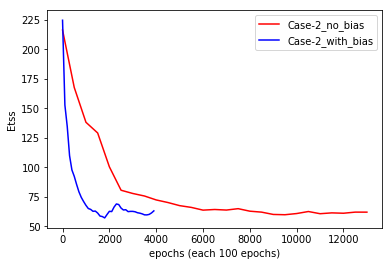

In [54]:
plt.plot(epochs_2a, Etss_2a,'r')
plt.plot(epochs_2b, Etss_2b,'b')
plt.legend(["Case-2_no_bias","Case-2_with_bias"])
plt.xlabel("epochs (each 100 epochs)")
plt.ylabel("Etss")

Text(0,0.5,'Etss')

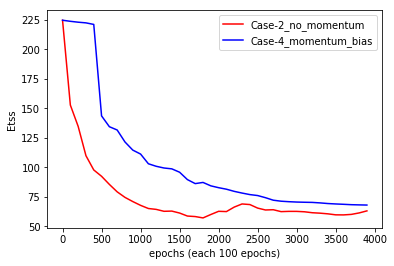

In [55]:
plt.plot(epochs_2b, Etss_2b,'r')
plt.plot(epochs_4a, Etss_4a,'b')
plt.legend(["Case-2_no_momentum","Case-4_momentum_bias"])
plt.xlabel("epochs (each 100 epochs)")
plt.ylabel("Etss")

Text(0,0.5,'Sensitivity')

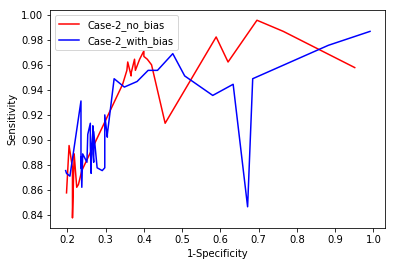

In [56]:
ind= np.argsort(specif_2a)
specif_2a = np.array(specif_2a)[ind]
sens_2a = np.array(sens_2a)[ind]


ind= np.argsort(specif_2b)
specif_2b = np.array(specif_2b)[ind]
sens_2b = np.array(sens_2b)[ind]

plt.plot(1-np.array(specif_2a), sens_2a,'r')
plt.plot(1-np.array(specif_2b), sens_2b,'b')
plt.legend(["Case-2_no_bias","Case-2_with_bias"])
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")

Text(0,0.5,'Sensitivity')

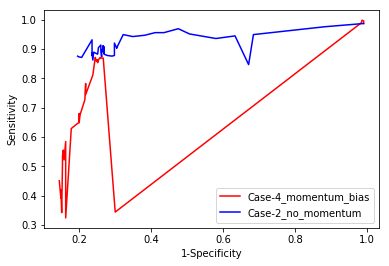

In [57]:
ind= np.argsort(specif_4a)
specif_4a = np.array(specif_4a)[ind]
sens_4a = np.array(sens_4a)[ind]


ind= np.argsort(specif_2b)
specif_2b = np.array(specif_2b)[ind]
sens_2b = np.array(sens_2b)[ind]

plt.plot(1-np.array(specif_4a), sens_4a,'r')
plt.plot(1-np.array(specif_2b), sens_2b,'b')
plt.legend(["Case-4_momentum_bias","Case-2_no_momentum"])
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")